# Imports

In [1]:
import os   # For path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Config GPU env

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12487351033144172317
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 216791188764224757
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Def NN

## Training options

In [3]:
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights.hdf5", save_best_only=True, verbose =1)

## Create a 1D convnet based on the practice lesson for time series analysis

In [4]:
def make_1d_convnet(out_type,window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    # Defining input shape of the first layer based on desired output type
    if out_type == 'xyz':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    if out_type == 'rot':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    return model

## Create input and output format from raw data

In [5]:
def make_timeseries_instances(out_type,timeseries, window_size, nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    if out_type == 'xyz':
        X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
        for coord in range(3):
            np.roll(X[:,coord + 10],1) # Move xyz coordinates to the past
        np.delete(X,0,0)
    
    # We have 3 output signal: x, y and z position    
        y = timeseries[window_size:,-11:-8]
        np.delete(y,0,0)
        
    if out_type == 'rot':
        temp_arr=timeseries[:, np.r_[:10, 14:18]] # Load sensor data and orientation reference to input
        X = np.atleast_3d(np.array([temp_arr[start:start+window_size,:nb_inputs] for start in range(0,temp_arr.shape[0]-window_size)]))
        for coord in range(4):
            np.roll(X[:,coord + 10],1) # Move orientation coordinates to the past
        np.delete(X,0,0)
    
    # We have 4 output signal: Qx, Qy, Qz and Qw orientation    
        y = timeseries[window_size:,-7:-3]
        np.delete(y,0,0)
        
    return X,y

## Train the network on timeseries

In [6]:
def evalute_timeseries(out_type,timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    
    # Define in and output size based on output type
    if out_type == 'xyz':
        nb_inputs = nb_series - 8 # Only 12 inputs (previous x,y,z position is an input now)
        nb_outputs = 3
    if out_type == 'rot':
        nb_inputs = nb_series - 7 # Only 13 inputs (previous Qx,Qy,Qz and Qw orientation is an input now)
        nb_outputs = 4
    
    # Initialize model
    model= make_1d_convnet(out_type,window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    # Fill and split the input and output variables
    X,y = make_timeseries_instances(out_type,timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    # Load the best model for plotting
    bestmodel = load_model("CNN_weights.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    # Plot the results based on output type
    if out_type == 'xyz':
        # Plot predicted x vs target x
        plt.figure(0)
        plt.plot(preds[:,0],color = 'green', label = 'x pred')
        plt.plot(targets[:,0],color = 'red', label = 'x targ')
    
        # Plot predicted z vs target z
        plt.figure(1)
        plt.plot(preds[:,2],color = 'blue', label = 'z pred')
        plt.plot(targets[:,2],color = 'yellow', label = 'z targ')
    
        # Plot the predicted route vs original route on x-z plane
        plt.figure(2)
        plt.plot(preds[:,0],preds[:,2], label = 'xz pred')
        plt.plot(targets[:,0],targets[:,2], label = 'xz targ')
        
    if out_type == 'rot':
        plt.figure(0,figsize = (15,5))
        plt.plot(preds[:,0],color = 'red', label = 'Qx pred')
        plt.plot(targets[:,0],color = 'green', label = 'Qx targ')
        
        plt.figure(1,figsize = (15,5))
        plt.plot(preds[:,1],color = 'red', label = 'Qy pred')
        plt.plot(targets[:,1],color = 'green', label = 'Qy targ')
        
        plt.figure(2,figsize = (15,5))
        plt.plot(preds[:,2],color = 'red', label = 'Qz pred')
        plt.plot(targets[:,2],color = 'green', label = 'Qz targ')
        
        plt.figure(3,figsize = (15,5))
        plt.plot(preds[:,3],color = 'red', label = 'Qw pred')
        plt.plot(targets[:,3],color = 'green', label = 'Qw targ')

# Hyperas functions
## Input data processor

In [7]:
def data(timeseries): 
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 8 #only 12 inputs (previous x,y,z position is an input now)
    window_size = 20
    
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.15  * nb_samples)
    valid_size = int(0.15 * nb_samples)
    
    x_train, x_valid, x_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(x_train[:,inpt])
        x_train[:,inpt] = scaler.transform(x_train[:,inpt])
        x_valid[:,inpt] = scaler.transform(x_valid[:,inpt])
        x_test[:,inpt] = scaler.transform(x_test[:,inpt])
        
    return x_train, y_train, x_valid, y_valid, x_test, y_test

## Create a 1D CNN

In [8]:
def create_model(x_train, y_train, x_valid, y_valid, x_test, y_test):
    # Modifyable hyperparameters
    n_layer1 = {{choice([128, 256, 512])}}
    n_layer2 = {{choice([128, 256, 512])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([16, 31, 64])}}
    
    # Constant parameters
    window_size = 20
    filter_length = 5
    nb_outputs=3
    
    # Creating model
    model = Sequential()
    model.add(Conv1D(filters = n_layer1, kernel_size = filter_length, activation = 'relu', 
                   input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = n_layer2, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optim, metrics = ['mae'])
    
    # Training model
    result = model.fit(x_train, y_train,
              batch_size = n_batch,
              epochs = 150,
              verbose = 2,
              validation_data = (x_valid, y_valid),
              callbacks = [checkpointer,early_stopping],
              shuffle = True)
    
    # Result output
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

# Load data file

In [9]:
df = pd.read_csv('PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [10]:
df.head(2)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.02,0.001,1.0,0.0,0.0,0.0


# Set hyperparameters

In [11]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

# Train NN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             264       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 375
Trainable params: 375
Non-trainable params: 0
_________________________________________________________________
Train on 382

 - 1s - loss: 4.5765e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0037 - val_mean_absolute_error: 0.0424

Epoch 00036: val_loss did not improve from 0.00350
Epoch 37/500
 - 1s - loss: 4.2690e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0035 - val_mean_absolute_error: 0.0408

Epoch 00037: val_loss did not improve from 0.00350
Epoch 38/500
 - 1s - loss: 4.1911e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0032 - val_mean_absolute_error: 0.0382

Epoch 00038: val_loss improved from 0.00350 to 0.00316, saving model to CNN_weights.hdf5
Epoch 39/500
 - 1s - loss: 4.1388e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0032 - val_mean_absolute_error: 0.0400

Epoch 00039: val_loss did not improve from 0.00316
Epoch 40/500
 - 1s - loss: 4.0838e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0030 - val_mean_absolute_error: 0.0377

Epoch 00040: val_loss improved from 0.00316 to 0.00303, saving model to CNN_weights.hdf5
Epoch 41/500
 - 1s - loss: 4.1791e-04 - mean_absolute_error: 0.0147 - va

 - 1s - loss: 2.5474e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0017 - val_mean_absolute_error: 0.0286

Epoch 00079: val_loss did not improve from 0.00167
Epoch 80/500
 - 1s - loss: 2.2970e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0017 - val_mean_absolute_error: 0.0279

Epoch 00080: val_loss did not improve from 0.00167
Epoch 81/500
 - 1s - loss: 2.1567e-04 - mean_absolute_error: 0.0104 - val_loss: 0.0018 - val_mean_absolute_error: 0.0285

Epoch 00081: val_loss did not improve from 0.00167
Epoch 82/500
 - 1s - loss: 2.2901e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0017 - val_mean_absolute_error: 0.0276

Epoch 00082: val_loss did not improve from 0.00167
Epoch 83/500
 - 1s - loss: 2.3648e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0016 - val_mean_absolute_error: 0.0297

Epoch 00083: val_loss improved from 0.00167 to 0.00164, saving model to CNN_weights.hdf5
Epoch 84/500
 - 1s - loss: 2.3541e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0016 - val_mean_absolute_err


Epoch 00125: val_loss did not improve from 0.00152
Epoch 126/500
 - 1s - loss: 1.5954e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0016 - val_mean_absolute_error: 0.0269

Epoch 00126: val_loss did not improve from 0.00152
Epoch 127/500
 - 1s - loss: 1.7185e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0016 - val_mean_absolute_error: 0.0290

Epoch 00127: val_loss did not improve from 0.00152
Epoch 128/500
 - 1s - loss: 1.6472e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0017 - val_mean_absolute_error: 0.0280

Epoch 00128: val_loss did not improve from 0.00152
Epoch 129/500
 - 1s - loss: 1.5628e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0016 - val_mean_absolute_error: 0.0267

Epoch 00129: val_loss did not improve from 0.00152
Epoch 130/500
 - 1s - loss: 1.8667e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0016 - val_mean_absolute_error: 0.0265

Epoch 00130: val_loss did not improve from 0.00152
Epoch 131/500
 - 1s - loss: 1.5259e-04 - mean_absolute_error: 0.0086 - val_los

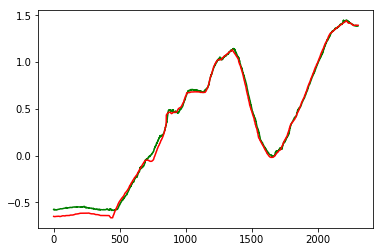

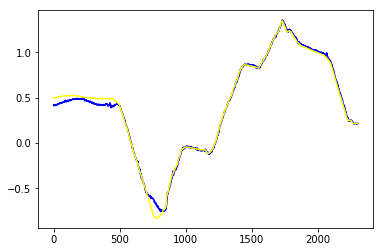

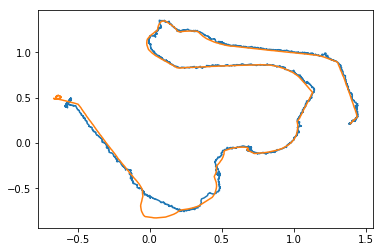

In [12]:
#use 'xyz' or 'rot' to choose output
evalute_timeseries('xyz',df,window_size,filter_length,nb_filter, epochs, batch_size)

# Draw xz position prediction with the model (previous position is the reference data)

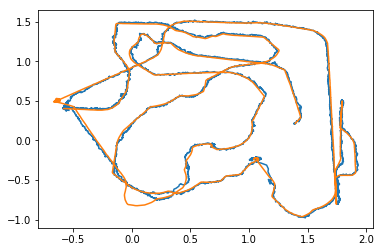

In [13]:
# Predict with reference dataset
X,y = make_timeseries_instances('xyz',df, window_size,nb_inputs=13)
model = load_model("CNN_weights.hdf5")
y_pred = model.predict(X)
plt.figure(0)
plt.plot(y_pred[:,0],y_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

# Draw xz position prediction with the model (previous position is predicted)

(7658, 20, 13)
(7658, 3)


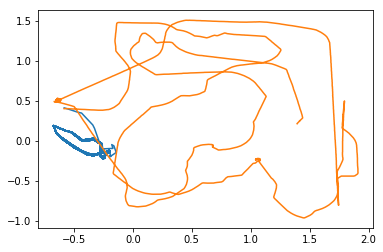

In [14]:
# Predict with calculated data
newX=X
print(newX.shape)
print(y.shape)

newy_pred=np.empty(y.shape)
for index in range(y.shape[0]-1):
    if index > 0:
        temp=newX[index,-1]
        newX[index]=np.roll(newX[index-1],-1, axis=0)
        newX[index,-1]=temp
        for coord in range(3):  
            newX[index,-1,coord+10]=newy_pred[index,coord]
    tmp=np.empty((1,20,13))
    tmp[0]=newX[index]
    newy_pred[index]=model.predict(tmp)
    
plt.figure(0)
plt.plot(newy_pred[:,0],newy_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

# Hyperas optimization

In [16]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# main hyperopt part
# az algoritmus lehet:
# -- random.suggest -> random search
# -- tpe.suggest -> tree parsen estimator
best_run, best_model = optim.minimize(model=create_model,
                                          data=data(df),
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='CNN_Mark')
#x_train, y_train, x_valid, y_valid, x_test, y_test = data(timeData)
#print("Evalutation of best performing model:")
#print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)


TypeError: make_timeseries_instances() missing 1 required positional argument: 'window_size'